# Water Classification XGBOOST Hyperparameter Tuning - Multi-GPU

Version: DEMO

ILAB Team

Kernel to use:
- (ADAPT PRISM 4x GPU instance) `Python [conda env:ilab]`

This is a demo notebook showcasing how the ILAB team uses full node (4x GPU in PRISM) capabilities to perform efficient hyperparameter tuning of the XGBoost classifier algorithm. This notebook also demonstates how to use a raster as a test data-set for the trained model.

In [1]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path
import sys

import xgboost as xgb

import optuna

import dask
from dask_cuda import LocalCUDACluster
from dask.distributed import Client

from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split 
from sklearn.inspection import permutation_importance

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#GDAL Stuff
from osgeo import gdalconst
from osgeo import gdal

from pprint import pprint

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
cluster = LocalCUDACluster()
client = Client(cluster)

distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize


In [3]:
cluster

In [4]:
client

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 754.59 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34677,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 754.59 GiB
Comm: tcp://10.100.38.5:46681,Total threads: 1
Dashboard: http://10.100.38.5:44945/status,Memory: 188.65 GiB
Nanny: tcp://127.0.0.1:42702,


In [5]:
GPU = True
DATA_TYPE = np.int16

In [6]:
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

Add names from above to this list to drop them from training and testing.

For example:

```python
columnsToDrop = ['sur_refl_b01_1', 'sur_refl_b07_1', 'ndwi1']
```

In [7]:
columnsToDrop = []

This is a 1000 row training dataset which has columns for all the features listed in v_names. MODIS MOD09GA and MOD09GQ were the data sources.

In [8]:
dfPath = '../data/WaterClassificationPowell.parquet.gzip'

In [9]:
outputRasterPath = '.'

In [10]:
df = pd.read_parquet(dfPath).astype(DATA_TYPE)
df = df.drop(columns=columnsToDrop)
X = df.drop(['water'], axis=1)
y = df['water']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [11]:
_ = [print(column) for column in X_train.columns]

sur_refl_b01_1
sur_refl_b02_1
sur_refl_b03_1
sur_refl_b04_1
sur_refl_b05_1
sur_refl_b06_1
sur_refl_b07_1
ndvi
ndwi1
ndwi2


In [12]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,720.0,1194.425000,1251.546112,8.0,232.50,881.5,1880.50,8900.0
sur_refl_b02_1,720.0,1549.977778,1522.776539,1.0,166.00,1290.5,2673.25,8617.0
sur_refl_b03_1,720.0,722.084722,929.663558,-100.0,274.75,544.0,846.25,8780.0
sur_refl_b04_1,720.0,1008.633333,999.331256,6.0,392.75,818.0,1299.50,8754.0
sur_refl_b05_1,720.0,1942.426389,1455.900707,-17.0,536.25,1818.5,3123.25,6382.0
sur_refl_b06_1,720.0,1916.252778,1534.327784,51.0,507.75,1527.0,3173.50,6610.0
sur_refl_b07_1,720.0,1580.554167,1382.346115,0.0,316.75,1204.0,2657.75,6128.0
ndvi,720.0,-5.094444,2567.278965,-9493.0,-1581.50,583.0,1732.75,6732.0
ndwi1,720.0,-2428.954167,3462.913914,-9862.0,-4676.50,-1694.5,-804.25,8685.0
ndwi2,720.0,-1094.434722,3837.975467,-9692.0,-2984.75,-766.0,674.25,10000.0


In [13]:
X_train.sample(5)

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
919,1513,2183,748,1249,2936,3214,2666,1812,-1910,-996
606,203,118,527,864,1642,1764,1658,-2647,-8746,-8671
439,1609,2615,797,1000,2143,1708,1107,2381,2098,4051
629,152,117,179,202,391,354,210,-1301,-5031,-2844
870,839,1827,371,624,2187,2035,1515,3705,-538,933


## XGBOOST

Choose which combination of hyperparameters to train:

- n_estimators: Number of learners for the xgboost to fit.
- booster: Which booster to use
- lamda: L2 regularization rate
- alpha: L1 regularization rate
- subsample: sampling ration for training data
- colsample_bytree: sampling according to each tree
- max_depth: maximum depth of the tree, signifies complexity
- min_child_weight: minimum child weight, the larger the term, the more complex
- gamme: how selective the algorithm is

In [14]:
from cuml.dask.common import utils as dask_utils    

In [15]:
X_train = dask.dataframe.from_pandas(X_train, npartitions=4)
X_val = dask.dataframe.from_pandas(X_val, npartitions=4)
y_train = dask.dataframe.from_pandas(y_train, npartitions=4)
y_val = dask.dataframe.from_pandas(y_val, npartitions=4)
X_test = dask.dataframe.from_pandas(X_test, npartitions=4)
y_test = dask.dataframe.from_pandas(y_test, npartitions=4)

In [16]:
workers = client.has_what().keys()
workers

dict_keys(['tcp://10.100.38.5:36918', 'tcp://10.100.38.5:38427', 'tcp://10.100.38.5:39625', 'tcp://10.100.38.5:46681'])

In [17]:
X_train, y_train = dask_utils.persist_across_workers(client, [X_train, y_train], workers=workers)
X_val, y_val = dask_utils.persist_across_workers(client, [X_val, y_val], workers=workers)
X_test, y_test = dask_utils.persist_across_workers(client, [X_test, y_test], workers=workers)

In [19]:
def objective(trial):
    hyperparameters = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "gpu_hist",
        "n_jobs": -1,
        "n_estimators": trial.suggest_categorical("n_estimators", [100, 150, 200, 250, 300, 350, 400]),
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.1, 0.3),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 0.3),
        # maximum depth of the tree, signifies complexity of the tree.
        "max_depth":  trial.suggest_int("max_depth", 3, 15, step=1), 
        # minimum child weight, larger the term more conservative the tree.
        "min_child_weight":  trial.suggest_int("min_child_weight", 2, 5), 
        "eta":  trial.suggest_float("eta", 1e-8, 1.0, log=True), 
        # defines how selective algorithm is.
        "gamma": trial.suggest_float("gamma", 1e-8, 0.5, log=True), 
        "grow_policy":  trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
    }
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_0-auc")
    classifier = xgb.dask.DaskXGBClassifier(**hyperparameters)
    classifier.client = client
    eval_set = [(X_train, y_train), (X_val, y_val)]
    eval_metric = ["error","auc"]
    classifier.fit(X_train, 
                   y_train, 
                   eval_set=eval_set, 
                   eval_metric=eval_metric, 
                   early_stopping_rounds=5, 
                   callbacks=[pruning_callback],
                   verbose=False)
    preds = classifier.predict(X_test)
    preds = preds.compute()
    y_test_series = y_test.compute()
    cm = confusion_matrix(y_test_series, preds)
    fp = cm[1][0]
    precision = precision_score(y_test_series, preds)
    f1 = f1_score(y_test_series, preds)
    print('Confusion matrix')
    print('TP: {:9} FN: {:9}'.format(cm[0][0], cm[0][1]))
    print('FP: {:9} TN: {:9}'.format(cm[1][0], cm[1][1]))
    print('Precision: {}'.format(precision))
    print('F1 score: {}'.format(f1))
    del classifier, preds
    return f1

## Set the search space

Set the search space for the hyperparameter tuning to search through once. This needs to be in conjunction with the `trial.suggest...` part of the hyperparameters dictionary defined aboce. 

Ex.

If `max_depth` is defined in `hyperparameters` in the `objective` function above as such

`"max_depth":  trial.suggest_int("max_depth", 3, 15, step=1),` 

then we need to pair that with the limited search space below as such:

`search_space={"max_depth":[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}`

This is not the most ideal way of ensuring that trials are not repeated, however it works for now. 

In [20]:
search_space={
    "max_depth":[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
}

### Set number of trials and timeout

Set the number of trials `n_trials=<num of desired trials>` and the maximum time for the total study `timeout=<timeout in minutes>*60`

In [21]:
optuna.logging.set_verbosity(optuna.logging.INFO)

study = optuna.create_study(study_name='xgboost hyperparameter tuning - multi-gpu', 
                            direction='maximize',
                           ) # sampler=optuna.samplers.GridSampler(search_space))

study.optimize(objective, n_trials=20, timeout=60*60)

[I 2022-04-04 16:47:53,615] A new study created in memory with name: xgboost hyperparameter tuning - multi-gpu
[16:47:54] task [xgboost.dask]:tcp://10.100.38.5:38427 got new rank 0
[16:47:54] task [xgboost.dask]:tcp://10.100.38.5:36918 got new rank 1
[16:47:54] task [xgboost.dask]:tcp://10.100.38.5:46681 got new rank 2
[16:47:54] task [xgboost.dask]:tcp://10.100.38.5:39625 got new rank 3
[I 2022-04-04 16:47:58,158] Trial 0 finished with value: 0.9735449735449735 and parameters: {'n_estimators': 200, 'booster': 'gbtree', 'lambda': 2.12565518379277e-07, 'alpha': 1.197340441283036e-05, 'subsample': 0.28002112439431603, 'colsample_bytree': 0.20730177719992338, 'max_depth': 3, 'min_child_weight': 5, 'eta': 2.6006596388320157e-06, 'gamma': 6.738156849411005e-05, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.9735449735449735.


Confusion matrix
TP:       103 FN:         2
FP:         3 TN:        92
Precision: 0.9787234042553191
F1 score: 0.9735449735449735


[16:47:58] task [xgboost.dask]:tcp://10.100.38.5:38427 got new rank 0
[16:47:58] task [xgboost.dask]:tcp://10.100.38.5:46681 got new rank 1
[16:47:58] task [xgboost.dask]:tcp://10.100.38.5:36918 got new rank 2
[16:47:58] task [xgboost.dask]:tcp://10.100.38.5:39625 got new rank 3
[I 2022-04-04 16:48:01,011] Trial 1 finished with value: 0.9680851063829788 and parameters: {'n_estimators': 200, 'booster': 'gbtree', 'lambda': 0.002362796904443501, 'alpha': 0.25880368435284523, 'subsample': 0.19219687482802977, 'colsample_bytree': 0.22786912697665054, 'max_depth': 9, 'min_child_weight': 5, 'eta': 1.031926750456535e-05, 'gamma': 4.0183618146595855e-06, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.9735449735449735.


Confusion matrix
TP:       103 FN:         2
FP:         4 TN:        91
Precision: 0.978494623655914
F1 score: 0.9680851063829788


[16:48:01] task [xgboost.dask]:tcp://10.100.38.5:39625 got new rank 0
[16:48:01] task [xgboost.dask]:tcp://10.100.38.5:46681 got new rank 1
[16:48:01] task [xgboost.dask]:tcp://10.100.38.5:36918 got new rank 2
[16:48:01] task [xgboost.dask]:tcp://10.100.38.5:38427 got new rank 3
[I 2022-04-04 16:48:04,097] Trial 2 finished with value: 0.9789473684210527 and parameters: {'n_estimators': 200, 'booster': 'dart', 'lambda': 0.07910734528993886, 'alpha': 0.9167375009755195, 'subsample': 0.18682884866052502, 'colsample_bytree': 0.2073770667623765, 'max_depth': 7, 'min_child_weight': 3, 'eta': 2.7580585256817158e-08, 'gamma': 1.1741957156947863e-08, 'grow_policy': 'lossguide'}. Best is trial 2 with value: 0.9789473684210527.


Confusion matrix
TP:       103 FN:         2
FP:         2 TN:        93
Precision: 0.9789473684210527
F1 score: 0.9789473684210527


[16:48:04] task [xgboost.dask]:tcp://10.100.38.5:38427 got new rank 0
[16:48:04] task [xgboost.dask]:tcp://10.100.38.5:46681 got new rank 1
[16:48:04] task [xgboost.dask]:tcp://10.100.38.5:39625 got new rank 2
[16:48:04] task [xgboost.dask]:tcp://10.100.38.5:36918 got new rank 3
[I 2022-04-04 16:48:07,377] Trial 3 finished with value: 0.9565217391304348 and parameters: {'n_estimators': 100, 'booster': 'dart', 'lambda': 2.4994114931280598e-06, 'alpha': 0.19710655384550133, 'subsample': 0.14227619201010194, 'colsample_bytree': 0.19767811363329563, 'max_depth': 14, 'min_child_weight': 5, 'eta': 0.01355385763820752, 'gamma': 9.754745793445555e-05, 'grow_policy': 'depthwise'}. Best is trial 2 with value: 0.9789473684210527.


Confusion matrix
TP:       104 FN:         1
FP:         7 TN:        88
Precision: 0.9887640449438202
F1 score: 0.9565217391304348


[16:48:07] task [xgboost.dask]:tcp://10.100.38.5:46681 got new rank 0
[16:48:07] task [xgboost.dask]:tcp://10.100.38.5:36918 got new rank 1
[16:48:07] task [xgboost.dask]:tcp://10.100.38.5:39625 got new rank 2
[16:48:07] task [xgboost.dask]:tcp://10.100.38.5:38427 got new rank 3
[I 2022-04-04 16:48:10,261] Trial 4 finished with value: 0.9789473684210527 and parameters: {'n_estimators': 250, 'booster': 'gbtree', 'lambda': 3.1237926159827905e-08, 'alpha': 1.607553204637239e-08, 'subsample': 0.27456007289284245, 'colsample_bytree': 0.12449851421980063, 'max_depth': 4, 'min_child_weight': 5, 'eta': 0.00017274000044391143, 'gamma': 0.12100694751850345, 'grow_policy': 'lossguide'}. Best is trial 2 with value: 0.9789473684210527.


Confusion matrix
TP:       103 FN:         2
FP:         2 TN:        93
Precision: 0.9789473684210527
F1 score: 0.9789473684210527


[16:48:10] task [xgboost.dask]:tcp://10.100.38.5:38427 got new rank 0
[16:48:10] task [xgboost.dask]:tcp://10.100.38.5:39625 got new rank 1
[16:48:10] task [xgboost.dask]:tcp://10.100.38.5:36918 got new rank 2
[16:48:10] task [xgboost.dask]:tcp://10.100.38.5:46681 got new rank 3
[I 2022-04-04 16:48:13,349] Trial 5 finished with value: 0.9791666666666666 and parameters: {'n_estimators': 250, 'booster': 'dart', 'lambda': 2.527484549899079e-08, 'alpha': 2.0533730454528096e-05, 'subsample': 0.26715788389015704, 'colsample_bytree': 0.1254116780335053, 'max_depth': 8, 'min_child_weight': 4, 'eta': 1.3519048314448689e-06, 'gamma': 0.0002835899905661779, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.9791666666666666.


Confusion matrix
TP:       102 FN:         3
FP:         1 TN:        94
Precision: 0.9690721649484536
F1 score: 0.9791666666666666


[16:48:13] task [xgboost.dask]:tcp://10.100.38.5:46681 got new rank 0
[16:48:13] task [xgboost.dask]:tcp://10.100.38.5:38427 got new rank 1
[16:48:13] task [xgboost.dask]:tcp://10.100.38.5:39625 got new rank 2
[16:48:13] task [xgboost.dask]:tcp://10.100.38.5:36918 got new rank 3
[I 2022-04-04 16:48:16,635] Trial 6 finished with value: 0.9789473684210527 and parameters: {'n_estimators': 250, 'booster': 'dart', 'lambda': 6.871409659887999e-07, 'alpha': 1.4704813036168371e-08, 'subsample': 0.1003959334430806, 'colsample_bytree': 0.16706446021570795, 'max_depth': 10, 'min_child_weight': 2, 'eta': 1.8205802565733343e-08, 'gamma': 0.00017240143803716495, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.9791666666666666.


Confusion matrix
TP:       103 FN:         2
FP:         2 TN:        93
Precision: 0.9789473684210527
F1 score: 0.9789473684210527


[16:48:16] task [xgboost.dask]:tcp://10.100.38.5:46681 got new rank 0
[16:48:16] task [xgboost.dask]:tcp://10.100.38.5:36918 got new rank 1
[16:48:16] task [xgboost.dask]:tcp://10.100.38.5:38427 got new rank 2
[16:48:17] task [xgboost.dask]:tcp://10.100.38.5:39625 got new rank 3
[I 2022-04-04 16:48:19,674] Trial 7 finished with value: 0.9508196721311476 and parameters: {'n_estimators': 350, 'booster': 'gbtree', 'lambda': 0.01802995068055792, 'alpha': 0.014754273042384978, 'subsample': 0.12329170956633312, 'colsample_bytree': 0.27545206041332704, 'max_depth': 3, 'min_child_weight': 5, 'eta': 1.501925491416828e-05, 'gamma': 7.402609100207296e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.9791666666666666.


Confusion matrix
TP:       104 FN:         1
FP:         8 TN:        87
Precision: 0.9886363636363636
F1 score: 0.9508196721311476


[16:48:19] task [xgboost.dask]:tcp://10.100.38.5:39625 got new rank 0
[16:48:19] task [xgboost.dask]:tcp://10.100.38.5:36918 got new rank 1
[16:48:20] task [xgboost.dask]:tcp://10.100.38.5:38427 got new rank 2
[16:48:20] task [xgboost.dask]:tcp://10.100.38.5:46681 got new rank 3
[I 2022-04-04 16:48:22,749] Trial 8 finished with value: 0.9735449735449735 and parameters: {'n_estimators': 250, 'booster': 'gbtree', 'lambda': 2.85624818800944e-05, 'alpha': 2.215921556732456e-08, 'subsample': 0.2931305561161508, 'colsample_bytree': 0.26195803521495065, 'max_depth': 11, 'min_child_weight': 5, 'eta': 0.006752810985475842, 'gamma': 0.11652879915794771, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.9791666666666666.


Confusion matrix
TP:       103 FN:         2
FP:         3 TN:        92
Precision: 0.9787234042553191
F1 score: 0.9735449735449735


[16:48:22] task [xgboost.dask]:tcp://10.100.38.5:38427 got new rank 0
[16:48:23] task [xgboost.dask]:tcp://10.100.38.5:36918 got new rank 1
[16:48:23] task [xgboost.dask]:tcp://10.100.38.5:46681 got new rank 2
[16:48:23] task [xgboost.dask]:tcp://10.100.38.5:39625 got new rank 3
[I 2022-04-04 16:48:25,765] Trial 9 finished with value: 0.9508196721311476 and parameters: {'n_estimators': 300, 'booster': 'gbtree', 'lambda': 0.003722336351177816, 'alpha': 2.7503808635946744e-07, 'subsample': 0.11286478618026237, 'colsample_bytree': 0.2641329253319062, 'max_depth': 12, 'min_child_weight': 4, 'eta': 0.022954636714839927, 'gamma': 1.5862442609486064e-07, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.9791666666666666.


Confusion matrix
TP:       104 FN:         1
FP:         8 TN:        87
Precision: 0.9886363636363636
F1 score: 0.9508196721311476


[16:48:26] task [xgboost.dask]:tcp://10.100.38.5:38427 got new rank 0
[16:48:26] task [xgboost.dask]:tcp://10.100.38.5:39625 got new rank 1
[16:48:26] task [xgboost.dask]:tcp://10.100.38.5:46681 got new rank 2
[16:48:26] task [xgboost.dask]:tcp://10.100.38.5:36918 got new rank 3
[I 2022-04-04 16:48:28,881] Trial 10 finished with value: 0.96875 and parameters: {'n_estimators': 400, 'booster': 'dart', 'lambda': 1.0210987708440088e-08, 'alpha': 0.0002905176743082224, 'subsample': 0.2389071923244969, 'colsample_bytree': 0.10087709826592474, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.5562586863863908, 'gamma': 0.010328820937432214, 'grow_policy': 'depthwise'}. Best is trial 5 with value: 0.9791666666666666.


Confusion matrix
TP:       101 FN:         4
FP:         2 TN:        93
Precision: 0.9587628865979382
F1 score: 0.96875


[16:48:29] task [xgboost.dask]:tcp://10.100.38.5:38427 got new rank 0
[16:48:29] task [xgboost.dask]:tcp://10.100.38.5:36918 got new rank 1
[16:48:29] task [xgboost.dask]:tcp://10.100.38.5:46681 got new rank 2
[16:48:29] task [xgboost.dask]:tcp://10.100.38.5:39625 got new rank 3
[I 2022-04-04 16:48:31,786] Trial 11 finished with value: 0.9625668449197862 and parameters: {'n_estimators': 150, 'booster': 'dart', 'lambda': 0.23583251541631178, 'alpha': 0.00010654287496349537, 'subsample': 0.1855601003984471, 'colsample_bytree': 0.1636866249587921, 'max_depth': 7, 'min_child_weight': 3, 'eta': 1.4743148351770779e-08, 'gamma': 1.240601933460584e-08, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.9791666666666666.


Confusion matrix
TP:       103 FN:         2
FP:         5 TN:        90
Precision: 0.9782608695652174
F1 score: 0.9625668449197862


[16:48:32] task [xgboost.dask]:tcp://10.100.38.5:36918 got new rank 0
[16:48:32] task [xgboost.dask]:tcp://10.100.38.5:46681 got new rank 1
[16:48:32] task [xgboost.dask]:tcp://10.100.38.5:39625 got new rank 2
[16:48:32] task [xgboost.dask]:tcp://10.100.38.5:38427 got new rank 3
[I 2022-04-04 16:48:35,182] Trial 12 finished with value: 0.96875 and parameters: {'n_estimators': 200, 'booster': 'dart', 'lambda': 0.8922170574096567, 'alpha': 0.0038731522689330073, 'subsample': 0.2331925854374584, 'colsample_bytree': 0.15465875998978734, 'max_depth': 7, 'min_child_weight': 4, 'eta': 3.6222438904787754e-07, 'gamma': 0.0018052444799200418, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.9791666666666666.


Confusion matrix
TP:       101 FN:         4
FP:         2 TN:        93
Precision: 0.9587628865979382
F1 score: 0.96875


[16:48:35] task [xgboost.dask]:tcp://10.100.38.5:38427 got new rank 0
[16:48:35] task [xgboost.dask]:tcp://10.100.38.5:36918 got new rank 1
[16:48:35] task [xgboost.dask]:tcp://10.100.38.5:46681 got new rank 2
[16:48:35] task [xgboost.dask]:tcp://10.100.38.5:39625 got new rank 3
[I 2022-04-04 16:48:38,230] Trial 13 finished with value: 0.9583333333333333 and parameters: {'n_estimators': 100, 'booster': 'dart', 'lambda': 0.00010849901615967599, 'alpha': 2.3013594608192376e-06, 'subsample': 0.23067575322557532, 'colsample_bytree': 0.22668174356567827, 'max_depth': 6, 'min_child_weight': 2, 'eta': 3.725381935400634e-07, 'gamma': 3.0382893356361613e-06, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.9791666666666666.


Confusion matrix
TP:       100 FN:         5
FP:         3 TN:        92
Precision: 0.9484536082474226
F1 score: 0.9583333333333333


[16:48:38] task [xgboost.dask]:tcp://10.100.38.5:38427 got new rank 0
[16:48:38] task [xgboost.dask]:tcp://10.100.38.5:36918 got new rank 1
[16:48:38] task [xgboost.dask]:tcp://10.100.38.5:46681 got new rank 2
[16:48:38] task [xgboost.dask]:tcp://10.100.38.5:39625 got new rank 3
[I 2022-04-04 16:48:41,247] Trial 14 finished with value: 0.9789473684210527 and parameters: {'n_estimators': 150, 'booster': 'dart', 'lambda': 0.00013756030418002172, 'alpha': 0.003509615202571283, 'subsample': 0.15078045885103286, 'colsample_bytree': 0.13219211464109665, 'max_depth': 9, 'min_child_weight': 3, 'eta': 2.4460442778610155e-07, 'gamma': 4.0203194017984775e-06, 'grow_policy': 'depthwise'}. Best is trial 5 with value: 0.9791666666666666.


Confusion matrix
TP:       103 FN:         2
FP:         2 TN:        93
Precision: 0.9789473684210527
F1 score: 0.9789473684210527


[16:48:41] task [xgboost.dask]:tcp://10.100.38.5:38427 got new rank 0
[16:48:41] task [xgboost.dask]:tcp://10.100.38.5:36918 got new rank 1
[16:48:41] task [xgboost.dask]:tcp://10.100.38.5:39625 got new rank 2
[16:48:41] task [xgboost.dask]:tcp://10.100.38.5:46681 got new rank 3
[I 2022-04-04 16:48:44,568] Trial 15 finished with value: 0.964102564102564 and parameters: {'n_estimators': 400, 'booster': 'dart', 'lambda': 8.67611441220166e-06, 'alpha': 8.555594229433245e-06, 'subsample': 0.16757951456792694, 'colsample_bytree': 0.19186803580452888, 'max_depth': 6, 'min_child_weight': 4, 'eta': 0.0003076790449096529, 'gamma': 0.0017308226627342803, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.9791666666666666.


Confusion matrix
TP:        99 FN:         6
FP:         1 TN:        94
Precision: 0.94
F1 score: 0.964102564102564


[16:48:44] task [xgboost.dask]:tcp://10.100.38.5:39625 got new rank 0
[16:48:44] task [xgboost.dask]:tcp://10.100.38.5:36918 got new rank 1
[16:48:44] task [xgboost.dask]:tcp://10.100.38.5:46681 got new rank 2
[16:48:45] task [xgboost.dask]:tcp://10.100.38.5:38427 got new rank 3
[I 2022-04-04 16:48:47,705] Trial 16 finished with value: 0.9740932642487047 and parameters: {'n_estimators': 300, 'booster': 'dart', 'lambda': 0.05193754148412964, 'alpha': 0.0004013513436272304, 'subsample': 0.21269167297971756, 'colsample_bytree': 0.29902264235764997, 'max_depth': 15, 'min_child_weight': 3, 'eta': 8.667372697823485e-08, 'gamma': 3.859286318664282e-07, 'grow_policy': 'lossguide'}. Best is trial 5 with value: 0.9791666666666666.


Confusion matrix
TP:       101 FN:         4
FP:         1 TN:        94
Precision: 0.9591836734693877
F1 score: 0.9740932642487047


[16:48:47] task [xgboost.dask]:tcp://10.100.38.5:46681 got new rank 0
[16:48:48] task [xgboost.dask]:tcp://10.100.38.5:36918 got new rank 1
[16:48:48] task [xgboost.dask]:tcp://10.100.38.5:39625 got new rank 2
[16:48:48] task [xgboost.dask]:tcp://10.100.38.5:38427 got new rank 3
[I 2022-04-04 16:48:50,796] Trial 17 finished with value: 0.9633507853403142 and parameters: {'n_estimators': 150, 'booster': 'dart', 'lambda': 0.0002937702069724493, 'alpha': 0.004211965086649731, 'subsample': 0.15622010407068607, 'colsample_bytree': 0.1326555156547197, 'max_depth': 9, 'min_child_weight': 4, 'eta': 1.0703822440459493e-06, 'gamma': 8.54386595055767e-06, 'grow_policy': 'depthwise'}. Best is trial 5 with value: 0.9791666666666666.


Confusion matrix
TP:       101 FN:         4
FP:         3 TN:        92
Precision: 0.9583333333333334
F1 score: 0.9633507853403142


[16:48:51] task [xgboost.dask]:tcp://10.100.38.5:38427 got new rank 0
[16:48:51] task [xgboost.dask]:tcp://10.100.38.5:39625 got new rank 1
[16:48:51] task [xgboost.dask]:tcp://10.100.38.5:46681 got new rank 2
[16:48:51] task [xgboost.dask]:tcp://10.100.38.5:36918 got new rank 3
[I 2022-04-04 16:48:53,935] Trial 18 finished with value: 0.9791666666666666 and parameters: {'n_estimators': 150, 'booster': 'dart', 'lambda': 0.0007073181271573423, 'alpha': 0.02050325530122068, 'subsample': 0.26393267828295736, 'colsample_bytree': 0.10057189500210298, 'max_depth': 11, 'min_child_weight': 2, 'eta': 2.6188166679976334e-05, 'gamma': 2.2392879443144304e-05, 'grow_policy': 'depthwise'}. Best is trial 5 with value: 0.9791666666666666.


Confusion matrix
TP:       102 FN:         3
FP:         1 TN:        94
Precision: 0.9690721649484536
F1 score: 0.9791666666666666


[16:48:54] task [xgboost.dask]:tcp://10.100.38.5:36918 got new rank 0
[16:48:54] task [xgboost.dask]:tcp://10.100.38.5:39625 got new rank 1
[16:48:54] task [xgboost.dask]:tcp://10.100.38.5:38427 got new rank 2
[16:48:54] task [xgboost.dask]:tcp://10.100.38.5:46681 got new rank 3
[I 2022-04-04 16:48:57,028] Trial 19 finished with value: 0.9791666666666666 and parameters: {'n_estimators': 350, 'booster': 'dart', 'lambda': 0.0005287253809828109, 'alpha': 0.036407345999447026, 'subsample': 0.257454252579101, 'colsample_bytree': 0.10057758921846302, 'max_depth': 13, 'min_child_weight': 2, 'eta': 3.5500056537914394e-05, 'gamma': 0.0005480956399874401, 'grow_policy': 'depthwise'}. Best is trial 5 with value: 0.9791666666666666.


Confusion matrix
TP:       102 FN:         3
FP:         1 TN:        94
Precision: 0.9690721649484536
F1 score: 0.9791666666666666


In [22]:
client.close()

In [23]:
print("Number of finished trials: {}".format(len(study.trials)))
trials = study.best_trials
trial_score = max([trial.values[0] for trial in trials])
best_trial_params = [trial.params for trial in trials if trial.values[0] == trial_score][0]
print(best_trial_params)
print(trial_score)

trial_scores = [trial.values for trial in trials]
trial_params = [trial.params for trial in trials]

study_df = study.trials_dataframe()
study_df.to_csv("hyperopt_tuning_trial_{}_xgboost.csv".format(
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')))

Number of finished trials: 20
{'n_estimators': 250, 'booster': 'dart', 'lambda': 2.527484549899079e-08, 'alpha': 2.0533730454528096e-05, 'subsample': 0.26715788389015704, 'colsample_bytree': 0.1254116780335053, 'max_depth': 8, 'min_child_weight': 4, 'eta': 1.3519048314448689e-06, 'gamma': 0.0002835899905661779, 'grow_policy': 'lossguide'}
0.9791666666666666


In [24]:
study_df

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_booster,params_colsample_bytree,params_eta,params_gamma,params_grow_policy,params_lambda,params_max_depth,params_min_child_weight,params_n_estimators,params_subsample,state
0,0,0.973545,2022-04-04 16:47:53.620560,2022-04-04 16:47:58.157532,0 days 00:00:04.536972,1.197340e-05,gbtree,0.207302,2.600660e-06,6.738157e-05,depthwise,2.125655e-07,3,5,200,0.280021,COMPLETE
1,1,0.968085,2022-04-04 16:47:58.160650,2022-04-04 16:48:01.010970,0 days 00:00:02.850320,2.588037e-01,gbtree,0.227869,1.031927e-05,4.018362e-06,lossguide,2.362797e-03,9,5,200,0.192197,COMPLETE
2,2,0.978947,2022-04-04 16:48:01.013379,2022-04-04 16:48:04.096711,0 days 00:00:03.083332,9.167375e-01,dart,0.207377,2.758059e-08,1.174196e-08,lossguide,7.910735e-02,7,3,200,0.186829,COMPLETE
3,3,0.956522,2022-04-04 16:48:04.099638,2022-04-04 16:48:07.376590,0 days 00:00:03.276952,1.971066e-01,dart,0.197678,1.355386e-02,9.754746e-05,depthwise,2.499411e-06,14,5,100,0.142276,COMPLETE
4,4,0.978947,2022-04-04 16:48:07.379951,2022-04-04 16:48:10.260142,0 days 00:00:02.880191,1.607553e-08,gbtree,0.124499,1.727400e-04,1.210069e-01,lossguide,3.123793e-08,4,5,250,0.274560,COMPLETE
5,5,0.979167,2022-04-04 16:48:10.264517,2022-04-04 16:48:13.348618,0 days 00:00:03.084101,2.053373e-05,dart,0.125412,1.351905e-06,2.835900e-04,lossguide,2.527485e-08,8,4,250,0.267158,COMPLETE
6,6,0.978947,2022-04-04 16:48:13.351742,2022-04-04 16:48:16.633781,0 days 00:00:03.282039,1.470481e-08,dart,0.167064,1.820580e-08,1.724014e-04,lossguide,6.871410e-07,10,2,250,0.100396,COMPLETE
7,7,0.950820,2022-04-04 16:48:16.636820,2022-04-04 16:48:19.673312,0 days 00:00:03.036492,1.475427e-02,gbtree,0.275452,1.501925e-05,7.402609e-08,lossguide,1.802995e-02,3,5,350,0.123292,COMPLETE
8,8,0.973545,2022-04-04 16:48:19.676238,2022-04-04 16:48:22.747792,0 days 00:00:03.071554,2.215922e-08,gbtree,0.261958,6.752811e-03,1.165288e-01,lossguide,2.856248e-05,11,5,250,0.293131,COMPLETE
9,9,0.950820,2022-04-04 16:48:22.751330,2022-04-04 16:48:25.764712,0 days 00:00:03.013382,2.750381e-07,gbtree,0.264133,2.295464e-02,1.586244e-07,lossguide,3.722336e-03,12,4,300,0.112865,COMPLETE


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='#Trials', ylabel='Objective Value'>

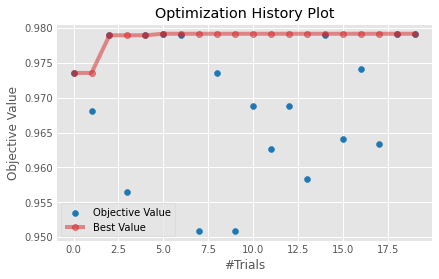

In [25]:
optuna.visualization.matplotlib.plot_optimization_history(study)

<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

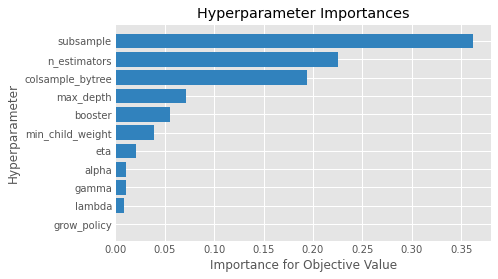

In [26]:
optuna.visualization.matplotlib.plot_param_importances(study)

## Define and train model given the best hyperparameters

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [28]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,800.0,1258.60125,1344.095620,8.0,241.00,901.0,1934.00,9045.0
sur_refl_b02_1,800.0,1624.11250,1588.654084,1.0,178.00,1456.5,2707.25,8795.0
sur_refl_b03_1,800.0,768.39625,1050.981398,-100.0,291.50,562.5,865.75,8844.0
sur_refl_b04_1,800.0,1061.28000,1110.586821,6.0,413.00,846.0,1348.50,9056.0
sur_refl_b05_1,800.0,2002.11750,1475.235337,-92.0,556.25,1829.0,3249.00,6382.0
sur_refl_b06_1,800.0,1963.58375,1559.615295,51.0,522.00,1503.0,3310.50,6610.0
sur_refl_b07_1,800.0,1619.51125,1411.311236,0.0,320.75,1189.0,2776.00,6128.0
ndvi,800.0,97.30875,2527.773586,-9493.0,-1353.00,761.0,1760.00,6732.0
ndwi1,800.0,-2280.26625,3460.266024,-9862.0,-4592.50,-1595.5,-773.00,8823.0
ndwi2,800.0,-893.60625,3850.669304,-9692.0,-2708.25,-708.5,817.00,10000.0


In [29]:
hyperparameters = best_trial_params

base_params = {"verbosity": 0,
               "objective": "binary:logistic",
               "tree_method": "hist",
               "n_jobs": -1}

hyperparameters.update(base_params)
print('Using these params:')
pprint(hyperparameters)
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["error","auc"]
classifier = xgb.XGBClassifier(**hyperparameters)

Using these params:
{'alpha': 2.0533730454528096e-05,
 'booster': 'dart',
 'colsample_bytree': 0.1254116780335053,
 'eta': 1.3519048314448689e-06,
 'gamma': 0.0002835899905661779,
 'grow_policy': 'lossguide',
 'lambda': 2.527484549899079e-08,
 'max_depth': 8,
 'min_child_weight': 4,
 'n_estimators': 250,
 'n_jobs': -1,
 'objective': 'binary:logistic',
 'subsample': 0.26715788389015704,
 'tree_method': 'hist',
 'verbosity': 0}


In [30]:
classifier.fit(X_train, y_train, eval_set=eval_set, eval_metric=eval_metric, early_stopping_rounds=10)

[0]	validation_0-error:0.07875	validation_0-auc:0.96476	validation_1-error:0.07000	validation_1-auc:0.97271
[1]	validation_0-error:0.05625	validation_0-auc:0.98495	validation_1-error:0.03500	validation_1-auc:0.99274
[2]	validation_0-error:0.08750	validation_0-auc:0.98242	validation_1-error:0.05500	validation_1-auc:0.99139
[3]	validation_0-error:0.04250	validation_0-auc:0.98871	validation_1-error:0.01500	validation_1-auc:0.99464
[4]	validation_0-error:0.02750	validation_0-auc:0.99631	validation_1-error:0.01500	validation_1-auc:0.99900
[5]	validation_0-error:0.02375	validation_0-auc:0.99701	validation_1-error:0.03000	validation_1-auc:0.99910
[6]	validation_0-error:0.01875	validation_0-auc:0.99808	validation_1-error:0.04000	validation_1-auc:0.99940
[7]	validation_0-error:0.02500	validation_0-auc:0.99815	validation_1-error:0.04000	validation_1-auc:0.99920
[8]	validation_0-error:0.02250	validation_0-auc:0.99771	validation_1-error:0.03500	validation_1-auc:0.99935
[9]	validation_0-error:0.020

XGBClassifier(alpha=2.0533730454528096e-05, base_score=0.5, booster='dart',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.1254116780335053, eta=1.3519048314448689e-06,
              gamma=0.0002835899905661779, gpu_id=-1, grow_policy='lossguide',
              importance_type='gain', interaction_constraints='',
              lambda=2.527484549899079e-08, learning_rate=1.35190487e-06,
              max_delta_step=0, max_depth=8, min_child_weight=4, missing=nan,
              monotone_constraints='()', n_estimators=250, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=2.0533731e-05,
              reg_lambda=2.52748436e-08, scale_pos_weight=1,
              subsample=0.26715788389015704, tree_method='hist',
              validate_parameters=1, verbosity=0)

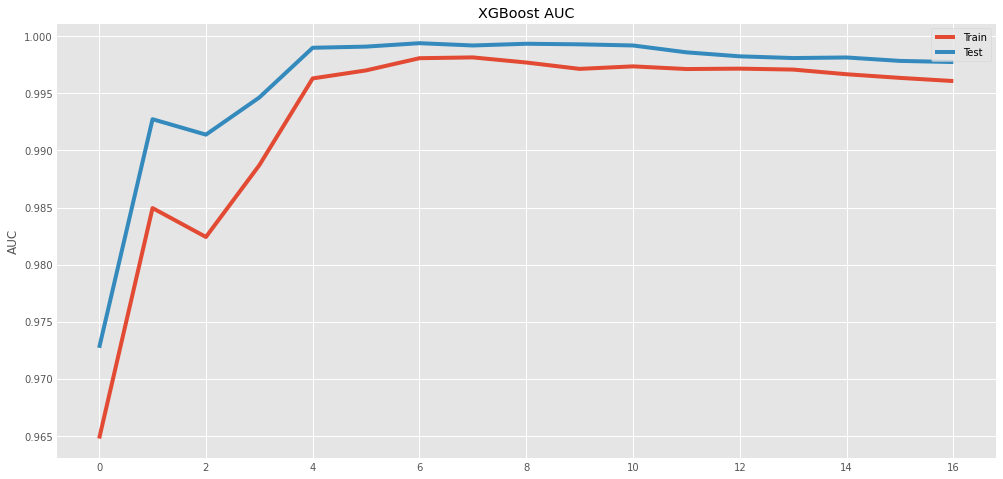

In [31]:
results = classifier.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

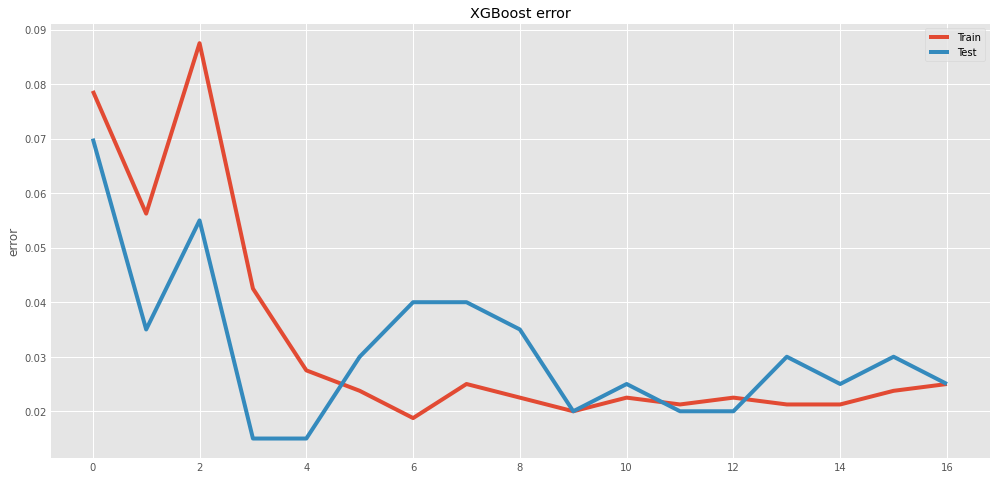

In [32]:
results = classifier.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('error')
plt.title('XGBoost error')
plt.show()

## Model testing and training/testing data validation

### Get model metrics

In [33]:
score = classifier.score(X_test, y_test)
score = round(score, 3)
score

0.96

In [34]:
train_predictions = classifier.predict(X_train)
test_predictions = classifier.predict(X_test)
prediction_probs = classifier.predict_proba(X_test)

In [35]:
test_predictions = test_predictions.astype(np.int16)
y_test_int = y_test.astype(np.int16)

In [36]:
print('Test Performance')
print('-------------------------------------------------------')
print(classification_report(y_test, test_predictions))
cm = confusion_matrix(y_test_int, test_predictions)
recall = (cm[0][0] / (cm[0][0] + cm[0][1]))
print('Test Recall')
print('-------------------------------------------------------')
print(recall)
print('Confusion Matrix')
print('-------------------------------------------------------')
print(cm)

Test Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        96
           1       1.00      0.92      0.96       104

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200

Test Recall
-------------------------------------------------------
1.0
Confusion Matrix
-------------------------------------------------------
[[96  0]
 [ 8 96]]


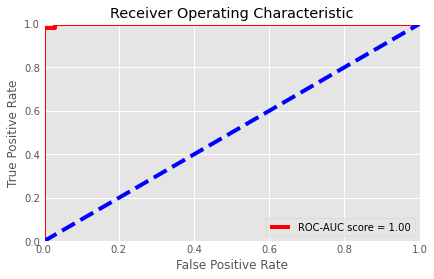

In [37]:
probs = classifier.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'red', label = 'ROC-AUC score = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Permutation importance

In [38]:
permutation_importance_results = permutation_importance(classifier,
                                                        X=X_test,
                                                        y=y_test,
                                                        n_repeats=10,
                                                        random_state=42)

Text(0.5, 0, 'Permutation Importance')

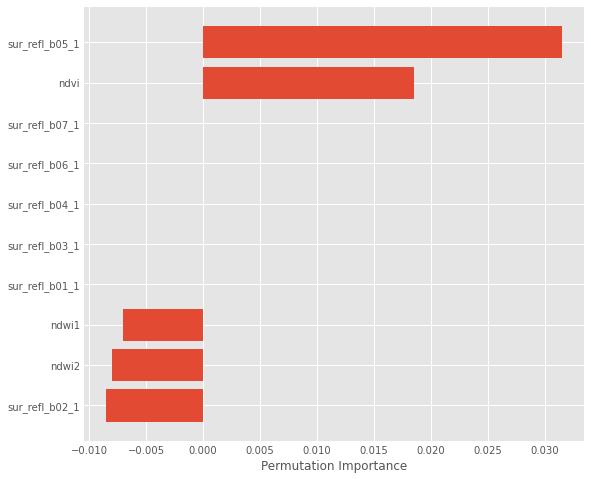

In [39]:
sorted_idx = permutation_importance_results.importances_mean.argsort()
plt.figure(figsize=(8, 8))
plt.barh(X_test.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [40]:
del X_train, X_test, y_train, y_test, test_predictions, train_predictions, y_test_int

## Save the model for future use

In [41]:
model_save_path = './water_classifier_xgb_tuned.sav'
print('Saving model to: {}'.format(model_save_path))
print(classifier)
joblib.dump(classifier, model_save_path, compress=3)

Saving model to: ./water_classifier_xgb_tuned.sav
XGBClassifier(alpha=2.0533730454528096e-05, base_score=0.5, booster='dart',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.1254116780335053, eta=1.3519048314448689e-06,
              gamma=0.0002835899905661779, gpu_id=-1, grow_policy='lossguide',
              importance_type='gain', interaction_constraints='',
              lambda=2.527484549899079e-08, learning_rate=1.35190487e-06,
              max_delta_step=0, max_depth=8, min_child_weight=4, missing=nan,
              monotone_constraints='()', n_estimators=250, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=2.0533731e-05,
              reg_lambda=2.52748436e-08, scale_pos_weight=1,
              subsample=0.26715788389015704, tree_method='hist',
              validate_parameters=1, verbosity=0)


['./water_classifier_xgb_tuned.sav']

# Testing: Raster testing

### Read in data 

These are modified MOD09GA and MOD09GQ products for the 2001 julian day 155. They were modified to be clipped to the Lake Powell region.

In [42]:
fileList = sorted([file for file in glob.glob('../data/IL.*.Powell.*.tif') if 'sur_refl' in file])

In [43]:
def readRastersToArray(fileList):
    rasterProjection = None
    newshp = (1300*1300, 10)
    img = np.empty(newshp, dtype=np.int16)
    for i, fileName in enumerate(fileList):
        ds = gdal.Open(fileName)
        img[:, i] = ds.GetRasterBand(1).ReadAsArray().astype(np.int16).ravel()
        if i == 0:
            rasterProjection = ds.GetProjection()
        ds = None
    img[:, len(fileList)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(fileList)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(fileList)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    return img, rasterProjection

In [44]:
%%time
im, rasterProjection = readRastersToArray(fileList)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

Raster as ndarray
[[ 1547  2461   857 ...  2280  -518   510]
 [ 1474  2377   857 ...  2344  -691   337]
 [ 1474  2377   846 ...  2344  -472   623]
 ...
 [ 2358  2979  1028 ...  1163 -1727 -1292]
 [ 2425  3069  1117 ...  1172 -1721 -1216]
 [ 2402  3038  1117 ...  1169 -1770 -1266]]
33.8 MB size
CPU times: user 495 ms, sys: 76.1 ms, total: 571 ms
Wall time: 835 ms


Columns to drop are also dropped for testing. 

In [45]:
def predictRaster(img_chunk, colsToDrop=None):
    """
    Function given a raster in the form of a nxn matrix, will
    convert the matrix to a GPU/CPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    df = pd.DataFrame(img_chunk, columns=v_names, dtype=np.int16)
    df = df.drop(columns=columnsToDrop)
    print('Making predictions from raster')
    predictions = classifier.predict(df).astype(np.int16)
    predictionsProbs = classifier.predict_proba(df).astype(np.float32)
    return predictions, predictionsProbs, df

In [46]:
%%time
predictedRaster, predictedProbaRaster, df = predictRaster(im)

Making predictions from raster
CPU times: user 37.2 s, sys: 30.6 ms, total: 37.2 s
Wall time: 1.17 s


In [47]:
shp = (1300, 1300)
left = list()
right = list()
for i, subarr in enumerate(predictedProbaRaster):
    left.append(subarr[0])
    right.append(subarr[1])
leftArr = np.asarray(left)
rightArr = np.asarray(right)
probaLand = leftArr.reshape(shp)
probaWater = rightArr.reshape(shp)

## Inputreshapet raster: description and histogram

In [48]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,1690000.0,2140.144561,807.227853,-100.0,1530.0,2292.0,2756.0,9424.0
sur_refl_b02_1,1690000.0,3276.677008,741.654344,-28672.0,2793.0,3303.0,3780.0,8909.0
sur_refl_b03_1,1690000.0,954.288317,357.504891,-100.0,741.0,963.0,1148.0,7929.0
sur_refl_b04_1,1690000.0,1547.173863,505.923213,-100.0,1199.0,1577.0,1858.0,8526.0
sur_refl_b05_1,1690000.0,3897.447927,875.726008,-95.0,3277.0,3993.0,4528.0,9440.0
sur_refl_b06_1,1690000.0,4009.725915,1122.289522,83.0,3151.0,4271.0,4863.0,8326.0
sur_refl_b07_1,1690000.0,3465.508279,1221.271953,-28672.0,2504.0,3777.0,4416.0,6657.0
ndvi,1690000.0,2338.848757,1416.787988,-31900.0,1525.0,1854.0,2682.0,32203.0
ndwi1,1690000.0,-907.298652,1020.379711,-32272.0,-1428.0,-1105.0,-627.0,32558.0
ndwi2,1690000.0,-30.655925,1514.628116,-32539.0,-886.0,-506.0,367.0,32702.0


#### Reshape the unravelled matrix back to the 1300x1300 raster shape

In [49]:
matrix = np.asarray(predictedRaster)
reshp = matrix.reshape(shp)
reshp.shape

(1300, 1300)

Apply the pixel QA mask to the results.

In [50]:
qa = [file for file in glob.glob('../data/*.tif') if 'qa' in file][0]
ds = gdal.Open(qa)
qaMask = ds.GetRasterBand(1).ReadAsArray()
output = np.where(qaMask == 0, reshp, -9999)
qaMask

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

# Generating stats for predicted and truth

In [51]:
countNoData = np.count_nonzero(output == -9999)
countLand = np.count_nonzero(output == 0)
countWater = np.count_nonzero(output == 1)
print('Predicted\n No-data occuraces: {}\n Land occurances: {}\n Water occurances: {}'.format(countNoData, countLand, countWater))

Predicted
 No-data occuraces: 61568
 Land occurances: 1619905
 Water occurances: 8527


In [52]:
geoTransform = (-9961223.407, 231.65635, 0.0, 4285642.633667, 0.0, -231.65635)

In [53]:
predictedPath = os.path.join(outputRasterPath, 'PowellPredictedWaterMask.tif')

driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(predictedPath, 1300, 1300, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geoTransform)
outDs.SetProjection(rasterProjection)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(output)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

## View predictions with Folium

In [54]:
import folium
from folium import plugins

sys.path.append('../scripts')
import folium_helper

In [55]:
mask_3857 = folium_helper.reproject_to_3857(predictedPath)
mask_d = folium_helper.get_bounds(mask_3857)
mask_b1 = folium_helper.open_and_get_band(mask_3857, 1)
folium_helper.cleanup(mask_3857)
mask_b1 = np.where(mask_b1 == -9999, 0, mask_b1)
zeros = np.zeros_like(mask_b1)
mask_rgb = np.dstack((mask_b1, zeros, zeros))

Transform: | 491.82, 0.00,-12749861.52|
| 0.00,-491.82, 4656230.30|
| 0.00, 0.00, 1.00|
Width: 1670 Height: 770


In [56]:
m = folium.Map(location=[mask_d['center'][1], mask_d['center'][0]],
                   tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom_start = 6, attr='Google')

In [57]:
m.add_child(folium_helper.get_overlay(mask_rgb, mask_d, 'Water classification XGBOOST predicted mask', opacity=0.6))
m.add_child(plugins.MousePosition())
m.add_child(folium.LayerControl())